# **Wake-word detection system**

**Breve motivación:**
 
1. Sistema a implementar 

2. Limitaciones del dispositivo embebido a utilizar 

    2.1 Preparación del dataset
    2.2 Diseño de red
...

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  

import core
import utils
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix

from model import make_esp32_keyword_model

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
print(tf.config.list_physical_devices('GPU'))

[]


2025-12-11 13:57:44.529125: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## Dataset

```json
@article{speechcommandsv2,
   author = { {Warden}, P.},
    title = "{Speech Commands: A Dataset for Limited-Vocabulary Speech Recognition}",
  journal = {ArXiv e-prints},
  archivePrefix = "arXiv",
  eprint = {1804.03209},
  primaryClass = "cs.CL",
  keywords = {Computer Science - Computation and Language, Computer Science - Human-Computer Interaction},
    year = 2018,
    month = apr,
    url = {https://arxiv.org/abs/1804.03209},
}
```

#### Preprocesamiento y *embedding* de los datos

In [ ]:
sample_rate = 16000
clip_duration_ms = 1000
nfft = 512
window_size_ms = 30.0
window_stride_ms = 20.0
nfilt = 40

BATCH_SIZE = 64

def build_features_dataset(ds, model_settings):
    features_list = []
    label_list = []

    for audio, label in ds.unbatch():              
        audio_np = audio.numpy().astype(np.float32)

        features = core.wav_to_features(audio_np, model_settings)
        # Expand channel dimension for CNNs → (frames, coeffs, 1)
        features = np.expand_dims(features, axis=-1)
        features_list.append(features)
        label_list.append(label.numpy())

    features_array = np.array(features_list, dtype=np.float32)
    ds_out = tf.data.Dataset.from_tensor_slices((features_array, label_list))
    return ds_out

Se utilizan los siguientes comandos para asignar memoria GPU al dataset a utilizar:

In [ ]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory="data/speech_commands/train", batch_size=BATCH_SIZE,
    validation_split=0.2, seed=0, output_sequence_length=16000, subset='both')

test_ds = tf.keras.utils.audio_dataset_from_directory(
    directory="data/speech_commands/test", batch_size=BATCH_SIZE,
    validation_split=0.0, seed=0, output_sequence_length=16000)

label_names = np.array(train_ds.class_names)
print("Label names:", label_names)

model_settings = core.prepare_model_settings( 
    sample_rate=sample_rate, clip_duration_ms=clip_duration_ms, nfft=nfft, 
    window_size_ms=window_size_ms, window_stride_ms=window_stride_ms, nfilt=nfilt) 
print(f'Model settings: {model_settings}')

print("Building MFCC training dataset...")
train_mfcc_ds = build_features_dataset(train_ds, model_settings)
print("Building MFCC validation dataset...")
val_mfcc_ds = build_features_dataset(val_ds, model_settings)
print("Building MFCC test dataset...")
test_mfcc_ds = build_features_dataset(test_ds, model_settings)

train_mfcc_ds = train_mfcc_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_mfcc_ds = val_mfcc_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_mfcc_ds = test_mfcc_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

FileNotFoundError: [Errno 2] No such file or directory: 'data/speech_commands/train'

Se observa que las palabras utilizadas son "up" y "down" esto por que a nivel de *features* no son entradas correlacionadas en cuanto a contenido en frecuencia o cercanía de bines en frecuencia.

### Inspección dataset

In [ ]:
for example_features, example_labels in train_mfcc_ds.take(1):
        break

cnt = 0
for batch, _ in train_mfcc_ds:
    cnt += 1
print("Num batches:", cnt)

input_shape = example_features.shape[1:]  
print('Input shape:', input_shape)
num_labels = len(label_names)
print('Num labels:', num_labels)

Num batches: 208
Input shape: (49, 40, 1)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 49, 40, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 25, 20, 64)     │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 25, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d                │ (None, 25, 20, 64)     │           576 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 25, 20, 16)     │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 25, 20, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25, 20, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_1              │ (None, 25, 20, 16)     │           144 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 20, 16)     │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 25, 20, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 16)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,612 (57.08 KB)

 Trainable params: 14,612 (57.08 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200


I0000 00:00:1765459194.354911    8151 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


208/208 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.5361 - loss: 1.0337 - val_accuracy: 0.6325 - val_loss: 0.8752
Epoch 2/200
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6609 - loss: 0.7621 - val_accuracy: 0.7341 - val_loss: 0.6237
Epoch 3/200
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7335 - loss: 0.6090 - val_accuracy: 0.7823 - val_loss: 0.5353
Epoch 4/200
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7883 - loss: 0.5111 - val_accuracy: 0.8001 - val_loss: 0.4804
Epoch 5/200
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8127 - loss: 0.4641 - val_accuracy: 0.8037 - val_loss: 0.4775
Epoch 6/200
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8242 - loss: 0.4363 - val_accuracy: 0.8306 - val_loss: 0.4263
Epoch 7/200
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8355 - loss: 0.4116 - val_accuracy: 0.8529 - val_loss: 0.3819
Epoch 8/200
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8471 - loss: 0.3817 - val_accuracy: 0.86

### **Modelo**

In [ ]:

model = make_esp32_keyword_model(input_shape, num_labels)
model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

### **Entrenamiento**

In [ ]:
EPOCHS = 200
history = model.fit(
    train_mfcc_ds,
    validation_data=val_mfcc_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=8, restore_best_weights=True),
)

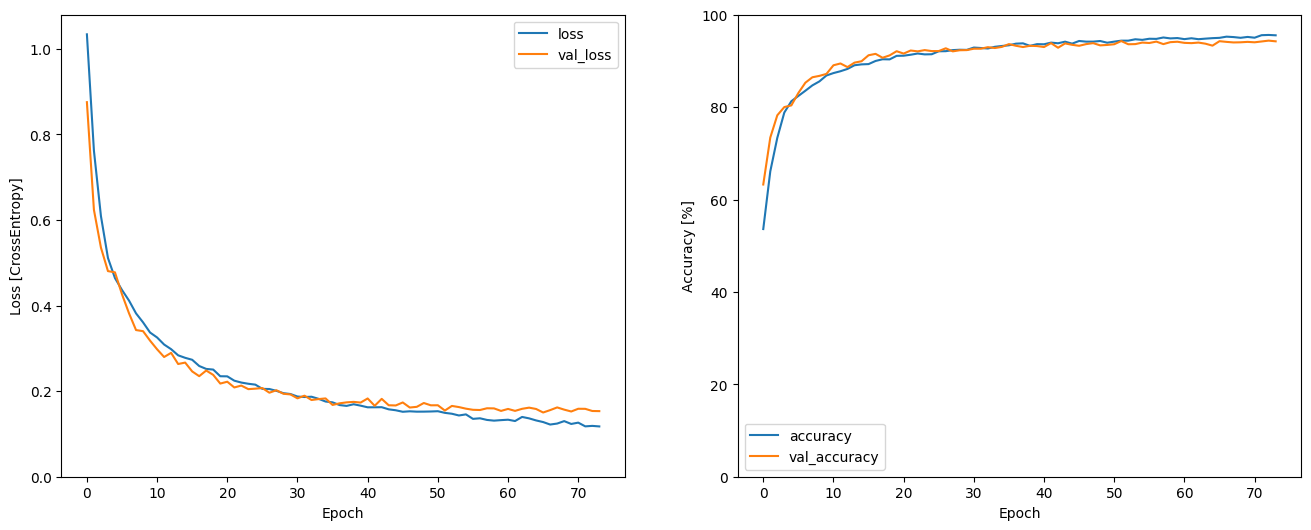

In [ ]:
utils.plot_training_history(history=history)

epochs = history.epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

history_array = np.column_stack([epochs, loss, val_loss, accuracy, val_accuracy])
header = "epoch,loss,val_loss,accuracy,val_accuracy"
np.savetxt("training_history.csv", history_array, delimiter=",", header=header, comments='')

### Evaluación modelo

In [ ]:
evs = model.evaluate(test_mfcc_ds, return_dict=True)
accuracy = evs['accuracy']
loss = evs['loss']
print(f'Test set accuracy: {accuracy*100:.2f}%')
print(f'Test set loss: {loss:.4f}')

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9513 - loss: 0.1977


{'accuracy': 0.9512711763381958, 'loss': 0.19766546785831451}

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


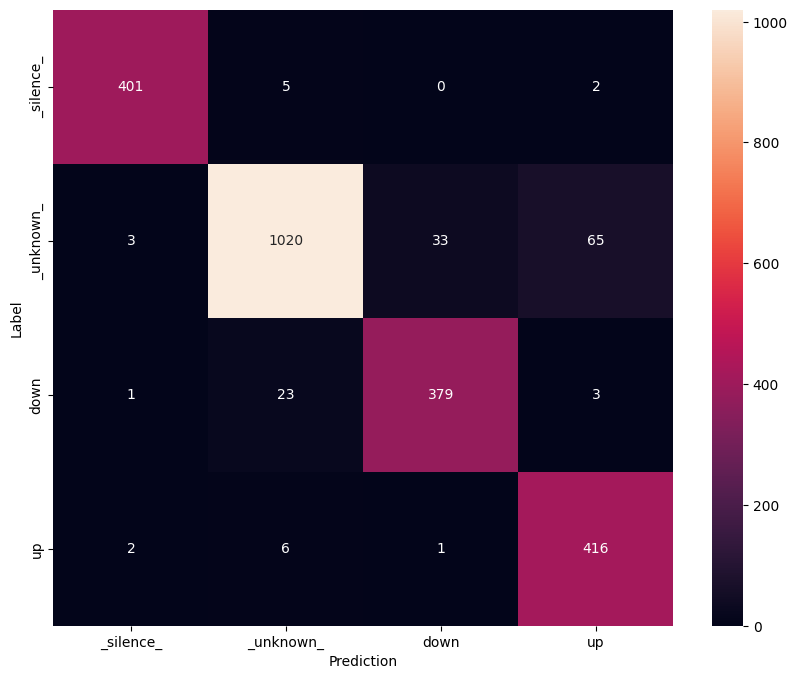

In [7]:
y_pred = model.predict(test_mfcc_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_mfcc_ds.map(lambda s,lab: lab)), axis=0)

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

---

## Modelo Embebido

In [ ]:
model.save('keyword_model.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

save_dir = 'model_exports'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
save_path = os.path.join(save_dir, 'model.tflite')
with open(save_path, 'wb') as f:    
    f.write(tflite_model)
print("TFLite model saved to:", save_path)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter.convert()
quantized_save_path = os.path.join(save_dir, 'model_quant.tflite')
with open(quantized_save_path, 'wb') as f:
    f.write(quantized_tflite_model)
print("Quantized TFLite model saved to:", quantized_save_path)

INFO:tensorflow:Assets written to: /tmp/tmpnc3_1o6u/assets


INFO:tensorflow:Assets written to: /tmp/tmpnc3_1o6u/assets


Saved artifact at '/tmp/tmpnc3_1o6u'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 49, 40, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  132213273344160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132213273343456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132213273343104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132213273339056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132213273336416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132213273336768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132213273342928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132213273400720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132213273400192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132213273395616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132213273400016:

W0000 00:00:1765314866.142555   91839 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1765314866.142567   91839 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
I0000 00:00:1765314866.147953   91839 mlir_graph_optimization_pass.cc:437] MLIR V1 optimization pass is not enabled


INFO:tensorflow:Assets written to: /tmp/tmp_rnyk4b6/assets


INFO:tensorflow:Assets written to: /tmp/tmp_rnyk4b6/assets


Saved artifact at '/tmp/tmp_rnyk4b6'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 49, 40, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  132213273344160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132213273343456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132213273343104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132213273339056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132213273336416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132213273336768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132213273342928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132213273400720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132213273400192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132213273395616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132213273400016:

W0000 00:00:1765314866.534798   91839 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1765314866.534808   91839 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.


Podemos explorar el modelo *tflite* para su posterior programación en C++ (ESP32 - Firmware)

In [ ]:
print("\nLoading TFLite quantized model...")
model_path = 'model_exports/model_quant.tflite'
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

for op in interpreter._get_ops_details():
    print(op["op_name"])

file_size = os.path.getsize("model_exports/model_quant.tflite")
print("Model file size:", file_size, "bytes")

In [ ]:
def dataset_to_numpy(ds):
    xs = []
    ys = []
    for x, y in ds:
        xs.append(x.numpy())
        ys.append(y.numpy())
    return np.concatenate(xs, axis=0), np.concatenate(ys, axis=0)

def predict_tflite(X):
    preds = []

    for x in X:
        # Expand batch dimension
        x_in = x[np.newaxis, ...]

        # If quantized, transform to uint8
        if scale != 0:
            x_q = (x_in / scale + zero_point).astype(np.uint8)
        else:
            x_q = x_in.astype(np.float32)

        interpreter.set_tensor(input_index, x_q)
        interpreter.invoke()

        output = interpreter.get_tensor(output_index)[0]
        preds.append(output)

    return np.array(preds)

X_test, y_test = dataset_to_numpy(test_ds)
num_classes = len(np.unique(y_test))
print("Test set shape:", X_test.shape, y_test.shape)


# 1) Load FP32 (normal) model
fp32_model = tf.keras.models.load_model("model_exports/keyword_model.h5")
print("\nLoaded FP32 model.")

# Evaluate FP32 model
fp32_loss, fp32_acc = fp32_model.evaluate(test_ds, verbose=0)
print(f"\n FP32 Model — Loss: {fp32_loss:.4f}, Accuracy: {fp32_acc:.4f}")

fp32_probs = fp32_model.predict(X_test)
fp32_pred = np.argmax(fp32_probs, axis=1)

print("\nFP32 Classification Report:")
print(classification_report(y_test, fp32_pred))
print("\nFP32 Confusion Matrix:")
print(confusion_matrix(y_test, fp32_pred))


# 2) Load INT8 Quantized TFLite Model
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_index = input_details[0]["index"]
output_index = output_details[0]["index"]

# Quantization parameters
scale, zero_point = input_details[0]['quantization']
print(f"Input quantization params - scale: {scale}, zero_point: {zero_point}")

# Evaluate INT8 quantized model
tflite_probs = predict_tflite(X_test)
# If output is quantized, dequantize
out_scale, out_zero = output_details[0]['quantization']
if out_scale != 0:
    tflite_probs = out_scale * (tflite_probs - out_zero)

tflite_pred = np.argmax(tflite_probs, axis=1)
# Accuracy
tflite_acc = np.mean(tflite_pred == y_test)
print(f"\nINT8 TFLite Model — Accuracy: {tflite_acc:.4f}")

print("\nINT8 Classification Report:")
print(classification_report(y_test, tflite_pred))

print("\nINT8 Confusion Matrix:")
print(confusion_matrix(y_test, tflite_pred))


NameError: name 'test_mfcc_ds' is not defined

#### *Export* del modelo como *array* en C

Para incrustar el modelo TFLite dentro del firmware de la ESP32, primero se convierte a un arreglo C usando `xxd` (linux).

Ejecuta el siguiente comando:

```bash
xxd -i model_exports/model_quant.tflite > firmware/src/model_data.cc